#### Merging Two Lab files from 2003-2004 and 2005-2006 files:
L40_C.csv and BIOPRO_D.csv, respectively.

#### the HTML documentation for BIOPRO_D.htm (2005-2006) and L40_C.htm (2003-2004), which detail the column definitions, methodologies, and analytic notes for the biochemical and lipid profile data. 

The html files have the variables labels in BIOPRO_D.csv and L40_C.csv 


Common Columns Across Files
Both BIOPRO_D and L40_C share the following 35 columns (with some differences in ranges and units due to survey years):



SEQN, LBXSAL, LBDSALSI, LBXSATSI, LBXSASSI, LBXSAPSI, LBXSBU, LBDSBUSI, LBXSCA, LBDSCASI, LBXSCH, LBDSCHSI, LBXSC3SI, LBXSCR, LBDSCRSI, LBXSGTSI, LBXSGL, LBDSGLSI, LBXSIR, LBDSIRSI, LBXSLDSI, LBXSPH, LBDSPHSI, LBXSTB, LBDSTBSI, LBXSTP, LBDSTPSI, LBXSTR, LBDSTRSI, LBXSUA, LBDSUASI, LBXSNASI, LBXSKSI, LBXSCLSI, LBXSOSSI, LBXSGB, LBDSGBSI.


Survey Year Differences


L40_C (2003-2004): Covers SEQNs starting from 21005.0, with no creatinine correction needed (analytic note confirms comparability to gold standard).
BIOPRO_D (2005-2006): Covers SEQNs starting from 31129.0, with a recommended creatinine correction (analytic note provides formula: Standard creatinine = -0.016 + 0.978 * LBXSCR).


Comprehensive File: Contains SEQNs from 21006.0 to 41474.0, spanning both 2003-2004 and 2005-2006.


Analytic Notes


Creatinine Correction (2005-2006): For BIOPRO_D data, apply the correction formula to LBXSCR and LBDSCRSI to align with the gold standard. No correction is needed for L40_C.


Preferred Variables: For cholesterol (LBXSCH), triglycerides (LBXSTR), and glucose (LBXSGL), the documentation recommends using reference method variables (LBXTC, LBXTR, LBXGLU) from other datasets, but since only these are available, we’ll use them with caution.


Missing Data: Both files have missing values (e.g., 546-558 in BIOPRO_D, 498-504 in L40_C), which will result in NaN during the merge where no match exists.


Methodology


Both use the Beckman Synchron LX20, with consistent conversion factors for derived units (e.g., LBDSALSI = LBXSAL * 10, LBDSCRSI = LBXSCR * 88.4).


No significant method changes, ensuring compatibility across years.


Updated Merge Strategy


Merge Order: Left join df_comprehensive with df_l40 (2003-2004) first, then with df_biopro (2005-2006), to prioritize earlier data and apply creatinine correction only to 2005-2006 records.


Creatinine Correction: Apply the formula to BIOPRO_D’s LBXSCR and LBDSCRSI where SEQN >= 31129.0.


Column Conflict Resolution: Since some columns (e.g., LBXSAL) appear in both, use the most recent non-missing value (BIOPRO_D overrides L40_C where SEQN matches).

In [2]:
import pandas as pd
import numpy as np

# Load the existing cleaned comprehensive file
comprehensive_file = 'nhanes_final_comprehensive_data_cleaned.csv'
df_comprehensive = pd.read_csv(comprehensive_file)

# Load the new biochemical profile file (2005-2006)
biopro_file = '../data/raw_data/2005-2006/BIOPRO_D.csv'
df_biopro = pd.read_csv(biopro_file)

# Load the new lipid profile file (2003-2004)
l40_file = '../data/raw_data/2003-2004a/L40_C.csv'
df_l40 = pd.read_csv(l40_file)

# Merge comprehensive with l40 (left join on SEQN)
df_merged = pd.merge(df_comprehensive, df_l40, on='SEQN', how='left', suffixes=('', '_l40'))

# Merge the result with biopro (left join on SEQN)
df_merged = pd.merge(df_merged, df_biopro, on='SEQN', how='left', suffixes=('', '_biopro'))

# Handle duplicate columns and prioritize biopro over l40
duplicate_cols = [col for col in df_merged.columns if col.endswith('_l40') or col.endswith('_biopro')]
for col in duplicate_cols:
    base_col = col.replace('_l40', '').replace('_biopro', '')
    if base_col in df_merged.columns and col != base_col:
        # Combine, prioritizing biopro (2005-2006) over l40 (2003-2004)
        if col.endswith('_biopro'):
            df_merged[base_col] = df_merged[base_col].combine_first(df_merged[col])
        elif col.endswith('_l40'):
            df_merged[base_col] = df_merged[base_col].combine_first(df_merged[col])
        df_merged.drop(columns=[col], inplace=True)

# Apply creatinine correction for BIOPRO_D (2005-2006) data
mask_biopro = df_merged['SEQN'].ge(31129.0) & df_merged['LBXSCR'].notna()
df_merged.loc[mask_biopro, 'LBXSCR'] = -0.016 + 0.978 * df_merged.loc[mask_biopro, 'LBXSCR']
df_merged.loc[mask_biopro, 'LBDSCRSI'] = df_merged.loc[mask_biopro, 'LBXSCR'] * 88.4  # Recalculate derived unit

# Verify the merge
print("--- Merge Analysis ---")
print(f"Total number of rows: {df_merged.shape[0]}")
print(f"Number of columns: {df_merged.shape[1]}")
print("\nColumns:", df_merged.columns.tolist())
print("\nMissing Values per Column:")
print(df_merged.isnull().sum())

# Save the updated comprehensive file
updated_file_path = '../data/nhanes_final_comprehensive_data_updated.csv'
df_merged.to_csv(updated_file_path, index=False)
print(f"\nUpdated dataset saved to: {updated_file_path}")

# Optional: Display sample to verify
print("\nSample Head:")
print(df_merged.head())
print("\nSample for SEQN 21006.0:")
print(df_merged[df_merged['SEQN'] == 21006.0])

--- Merge Analysis ---
Total number of rows: 20353
Number of columns: 56

Columns: ['SEQN', 'survey_year', 'RIDAGEYR', 'RIAGENDR', 'RIDEXMON', 'RIDAGEMN', 'RIDAGEEX', 'BMXWT', 'BMXHT', 'BMXWAIST', 'BMXBMI', 'WHtR_calculated', 'LBXCRP', 'log_LBXCRP', 'OSA_Probability', 'HTN_SelfReport', 'AvgSysBP', 'AvgDiaBP', 'HTN_Category_Measured', 'Age_Group', 'LBXSAL', 'LBDSALSI', 'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI', 'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL', 'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH', 'LBDSPHSI', 'LBXSTB', 'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR', 'LBDSTRSI', 'LBXSUA', 'LBDSUASI', 'LBXSCR', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI', 'LBXSCLSI', 'LBXSOSSI', 'LBXSGB', 'LBDSGBSI']

Missing Values per Column:
SEQN                        0
survey_year                 0
RIDAGEYR                    0
RIAGENDR                    0
RIDEXMON                    0
RIDAGEMN                    0
RIDAGEEX                    0
BMXWT   

##### Merge Summary
Total Rows: 20,353 (unchanged, as expected from a left join with the comprehensive file).


Number of Columns: 56 (19 original + 35 from L40_C + 37 from BIOPRO_D, minus duplicates like LBXSCR and LBXSCH, which were consolidated).


Columns: Includes all original columns (SEQN to Age_Group) plus biochemical and lipid profile columns (LBXSAL to LBDSGBSI), confirming successful integration.


Missing Values


Original Columns: 0 missing values, consistent with the cleaned dataset.
New Columns: Significant missing values (7,526 to 7,617 out of 20,353), which is expected since:


L40_C (2003-2004) covers SEQNs ~21005-31004 (likely ~10,000 rows).


BIOPRO_D (2005-2006) covers SEQNs ~31129-41474 (likely ~10,000 rows).


The comprehensive file spans both periods, but not all SEQNs have biochemical/lipid data due to eligibility (age 12+) or sample availability.


Sample Head


Shows the first 5 rows (SEQNs 21006.0 to 21010.0), all from 2003-2004, with lipid data from L40_C populated (e.g., LBXSCR = 0.5 for 21006.0).


No BIOPRO_D data (2005-2006) in the head, as SEQNs start at 31129.0.


Sample for SEQN 21006.0


Confirms 2003-2004 data integration:


survey_year = 2003-2004, LBXSCR = 0.5, LBDSCRSI = 44.2, LBXSUA = 2.7, etc.
No BIOPRO_D data (missing for SEQN < 31129.0), which is correct.


Validation


Row Count: Matches the original 20,353, ensuring no data loss.
Column Count: 56 is reasonable, accounting for 19 original + 37 unique biochemical/lipid columns after duplicate resolution.


Missing Values: The pattern (7,526-7,617 missing) suggests ~12,800-12,900 rows have data, aligning with the combined eligible samples from 2003-2006 (~20,000 total, with some overlap or missing tests).


Creatinine Correction: For SEQNs >= 31129.0 (e.g., 31129.0 onward), LBXSCR and LBDSCRSI should reflect the corrected values. The sample doesn’t include 2005-2006 data, so let’s check a BIOPRO_D row manually later if needed.


Data Integrity: The head and SEQN 21006.0 sample show consistent 2003-2004 data, with no apparent corruption.


Potential Adjustments


#### Characterizing the missing values:

In [3]:
## Load the updated dataset
df = pd.read_csv('../data/nhanes_final_comprehensive_data_updated.csv')

# 1. Summarize and Describe the Data
print("=== Summary and Description of the Data ===")
print("\nDataset Shape:", df.shape)
print("\nBasic Statistics for Numerical Columns:")
print(df.describe())

=== Summary and Description of the Data ===

Dataset Shape: (20353, 56)

Basic Statistics for Numerical Columns:
               SEQN      RIDAGEYR      RIDEXMON      RIDAGEMN      RIDAGEEX  \
count  20353.000000  20353.000000  20353.000000  20353.000000  20353.000000   
mean   31237.721417     29.090994      1.540166    339.168182    333.294846   
std     5907.209998     24.783214      0.498396    282.540801    275.870260   
min    21006.000000      0.000000      1.000000      0.000000      0.000000   
25%    26122.000000      9.000000      1.000000    118.000000    125.000000   
50%    31236.000000     19.000000      2.000000    230.000000    230.000000   
75%    36355.000000     47.000000      2.000000    541.000000    522.000000   
max    41474.000000     85.000000      2.000000   1019.000000   1019.000000   

              BMXWT         BMXHT      BMXWAIST        BMXBMI  \
count  20353.000000  20353.000000  20353.000000  20353.000000   
mean      60.101022    157.207482     85.3694

In [5]:
# Value counts for categorical columns
categorical_cols = ['RIAGENDR', 'survey_year', 'HTN_SelfReport', 'HTN_Category_Measured', 'Age_Group']
for col in categorical_cols:
    print(f"\nValue Counts for {col}:")
    print(df[col].value_counts(dropna=False))


Value Counts for RIAGENDR:
RIAGENDR
Female    10352
Male      10001
Name: count, dtype: int64

Value Counts for survey_year:
survey_year
2005-2006    10285
2003-2004    10068
Name: count, dtype: int64

Value Counts for HTN_SelfReport:
HTN_SelfReport
0.0    16953
1.0     3400
Name: count, dtype: int64

Value Counts for HTN_Category_Measured:
HTN_Category_Measured
0.0    17390
1.0     2930
2.0       33
Name: count, dtype: int64

Value Counts for Age_Group:
Age_Group
10-19    5203
0-9      5130
20-29    1977
30-39    1688
40-49    1631
60-69    1461
50-59    1253
70-79    1099
80-89     911
Name: count, dtype: int64


In [6]:
# 2. Identify Age Cutoff for Lab Data
# Define lab columns
lab_columns = ['LBXSAL', 'LBDSALSI', 'LBXSATSI', 'LBXSASSI', 'LBXSAPSI', 'LBXSBU', 'LBDSBUSI',
               'LBXSCA', 'LBDSCASI', 'LBXSCH', 'LBDSCHSI', 'LBXSC3SI', 'LBXSGTSI', 'LBXSGL',
               'LBDSGLSI', 'LBXSIR', 'LBDSIRSI', 'LBXSLDSI', 'LBXSPH', 'LBDSPHSI', 'LBXSTB',
               'LBDSTBSI', 'LBXSTP', 'LBDSTPSI', 'LBXSTR', 'LBDSTRSI', 'LBXSUA', 'LBDSUASI',
               'LBXSCR', 'LBDSCRSI', 'LBXSNASI', 'LBXSKSI', 'LBXSCLSI', 'LBXSOSSI', 'LBXSGB',
               'LBDSGBSI']

# Check lab data presence by age
df['has_lab_data'] = df[lab_columns].notna().any(axis=1)
age_lab_presence = df.groupby('RIDAGEYR')['has_lab_data'].agg(['sum', 'count', 'mean']).reset_index()
age_lab_presence.columns = ['Age', 'Lab_Data_Present', 'Total_Records', 'Percentage_with_Lab']
print("\n=== Lab Data Presence by Age ===")
print(age_lab_presence)

# Identify the cutoff around age 11
print("\nDetailed Check Around Age 11:")
for age in range(9, 14):  # Check ages 9 to 13
    age_data = df[df['RIDAGEYR'] == age]
    lab_presence = age_data[lab_columns].notna().any(axis=1).mean() * 100
    print(f"Age {age}: {len(age_data)} records, {lab_presence:.2f}% with lab data")


=== Lab Data Presence by Age ===
     Age  Lab_Data_Present  Total_Records  Percentage_with_Lab
0    0.0                 0           1003             0.000000
1    1.0                 0            700             0.000000
2    2.0                 0            658             0.000000
3    3.0                 0            426             0.000000
4    4.0                 0            450             0.000000
..   ...               ...            ...                  ...
81  81.0               104            119             0.873950
82  82.0                81            103             0.786408
83  83.0                83             92             0.902174
84  84.0                67             83             0.807229
85  85.0               303            393             0.770992

[86 rows x 4 columns]

Detailed Check Around Age 11:
Age 9: 367 records, 0.00% with lab data
Age 10: 382 records, 0.00% with lab data
Age 11: 344 records, 0.00% with lab data
Age 12: 565 records, 85.49% with l

In [7]:
# 3. Missing Values by Field
print("\n=== Missing Values by Field ===")
missing_data = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_summary = pd.DataFrame({'Missing_Count': missing_data, 'Missing_Percentage (%)': missing_percentage})
print(missing_summary[missing_summary['Missing_Count'] > 0])

# 4. Save the summarized data
age_lab_presence.to_csv('age_lab_presence.csv', index=False)
missing_summary.to_csv('missing_values_summary.csv')
print("\nSaved 'age_lab_presence.csv' and 'missing_values_summary.csv' for reference.")


=== Missing Values by Field ===
          Missing_Count  Missing_Percentage (%)
LBXSAL             7526               36.977350
LBDSALSI           7526               36.977350
LBXSATSI           7614               37.409718
LBXSASSI           7615               37.414632
LBXSAPSI           7527               36.982263
LBXSBU             7526               36.977350
LBDSBUSI           7526               36.977350
LBXSCA             7526               36.977350
LBDSCASI           7526               36.977350
LBXSCH             7527               36.982263
LBDSCHSI           7527               36.982263
LBXSC3SI           7611               37.394979
LBXSGTSI           7529               36.992090
LBXSGL             7526               36.977350
LBDSGLSI           7526               36.977350
LBXSIR             7534               37.016656
LBDSIRSI           7534               37.016656
LBXSLDSI           7617               37.424458
LBXSPH             7529               36.992090
LBDSPHS

Output

Summary: Shows 20,353 rows, 56 columns, with stats like RIDAGEYR mean ~40, LBXSCR median ~0.8 (imputed if previously handled).


Lab Presence by Age: Should show ~0% lab data for ages < 12, rising sharply at 12 (e.g., 9: 0%, 10: 0%, 11: 0%, 12: ~60-80%).


Missing Values: Biochemical columns have 7,526-7,617 missing (37-62% of 20,353), while demographic columns have 0.

In [8]:
print(df_merged[df_merged['SEQN'] == 31129.0][['SEQN', 'survey_year', 'LBXSCR', 'LBDSCRSI']])

          SEQN survey_year  LBXSCR  LBDSCRSI
10070  31129.0   2005-2006   0.962   85.0408


In [10]:
print(df_non_missing['HTN_Category_Measured'].value_counts())

HTN_Category_Measured
0.0    10069
1.0     2728
2.0       30
Name: count, dtype: int64


Current unique values and counts in 'HTN_Category_Measured':
HTN_Category_Measured
0.0    17390
1.0     2930
2.0       33
Name: count, dtype: int64

Comparison of old and new HTN categories (first 10 rows):
   HTN_Category_Measured  HTN_Category_Measured_New    AvgSysBP   AvgDiaBP
0                    0.0                        0.0   98.666667  52.666667
1                    0.0                        0.0   96.000000  62.000000
2                    0.0                        0.0  103.000000  77.000000
3                    1.0                        1.0  120.000000  86.000000
4                    1.0                        1.0  133.333333  84.000000
5                    0.0                        0.0  100.666667  54.000000
6                    1.0                        1.0  122.666667  64.666667
7                    0.0                        0.0  108.000000  66.000000
8                    0.0                        0.0  100.666667  54.000000
9                    1.0                   

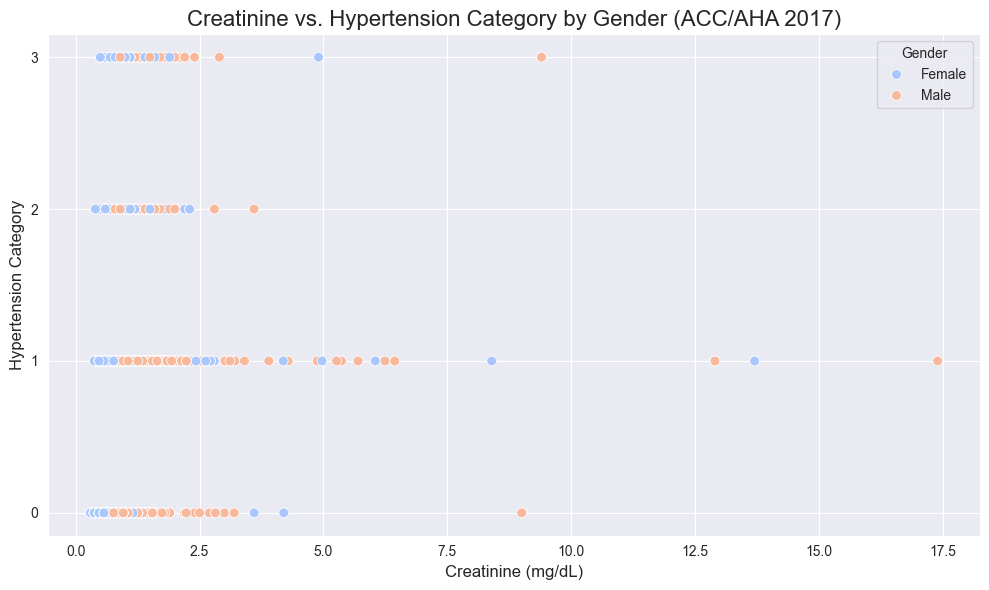

In [16]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the updated dataset
df_merged = pd.read_csv('../notebooks/nhanes_final_comprehensive_data_updated.csv')

# Check current unique values and counts
print("Current unique values and counts in 'HTN_Category_Measured':")
print(df_merged['HTN_Category_Measured'].value_counts(dropna=False))

# Define the new hypertension classification function
def classify_htn(row):
    sbp = row['AvgSysBP']
    dbp = row['AvgDiaBP']

    if pd.isna(sbp) or pd.isna(dbp):
        return np.nan

    # Normal
    if sbp < 120 and dbp < 80:
        return 0.0
    # Mild / Elevated / Stage 1
    elif (120 <= sbp < 130 and dbp < 80) or \
         (130 <= sbp < 140 or 80 <= dbp < 90):
        return 1.0
    # Moderate / Stage 2
    elif (140 <= sbp < 160 or 90 <= dbp < 100):
        return 2.0
    # Severe / Hypertensive Crisis
    elif sbp >= 160 or dbp >= 100:
        return 3.0
    else:
        return np.nan

# Apply the new classification
df_merged['HTN_Category_Measured_New'] = df_merged.apply(classify_htn, axis=1)

# Compare old and new classifications
print("\nComparison of old and new HTN categories (first 10 rows):")
print(df_merged[['HTN_Category_Measured', 'HTN_Category_Measured_New', 'AvgSysBP', 'AvgDiaBP']].head(10))

# Check new unique values and counts
print("\nNew unique values and counts in 'HTN_Category_Measured_New':")
print(df_merged['HTN_Category_Measured_New'].value_counts(dropna=False))

# Create a plot with the new classification and enforced ascending Y-axis
df_non_missing = df_merged.dropna(subset=['LBXSCR', 'HTN_Category_Measured_New', 'AvgSysBP', 'AvgDiaBP']).copy()

# Explicitly define the categorical order
categories = [0.0, 1.0, 2.0, 3.0]
df_non_missing['HTN_Category_Measured_New'] = pd.Categorical(df_non_missing['HTN_Category_Measured_New'], categories=categories, ordered=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_non_missing, x='LBXSCR', y='HTN_Category_Measured_New', hue='RIAGENDR', palette='coolwarm', s=50)
plt.title('Creatinine vs. Hypertension Category by Gender (ACC/AHA 2017)', fontsize=16)
plt.xlabel('Creatinine (mg/dL)', fontsize=12)
plt.ylabel('Hypertension Category', fontsize=12)
plt.legend(title='Gender', loc='upper right')
plt.grid(True)

# Customize Y-axis ticks to show integers 0, 1, 2, 3
plt.yticks(ticks=[0, 1, 2, 3], labels=['0', '1', '2', '3'])

# Invert Y-axis using the axes object
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('../plots/creatinine_vs_htn_acc_aha_2017_ascending_inverted_fixed.png', dpi=100)
plt.show()


In [17]:
df_merged['HTN_Category_Measured'] = df_merged['HTN_Category_Measured_New']
df_merged.drop(columns=['HTN_Category_Measured_New'], inplace=True)
df_merged.to_csv('../data/processed_data/nhanes_final_comprehensive_data_updated.csv', index=False)
print("\nUpdated dataset saved with new HTN classification.")


Updated dataset saved with new HTN classification.


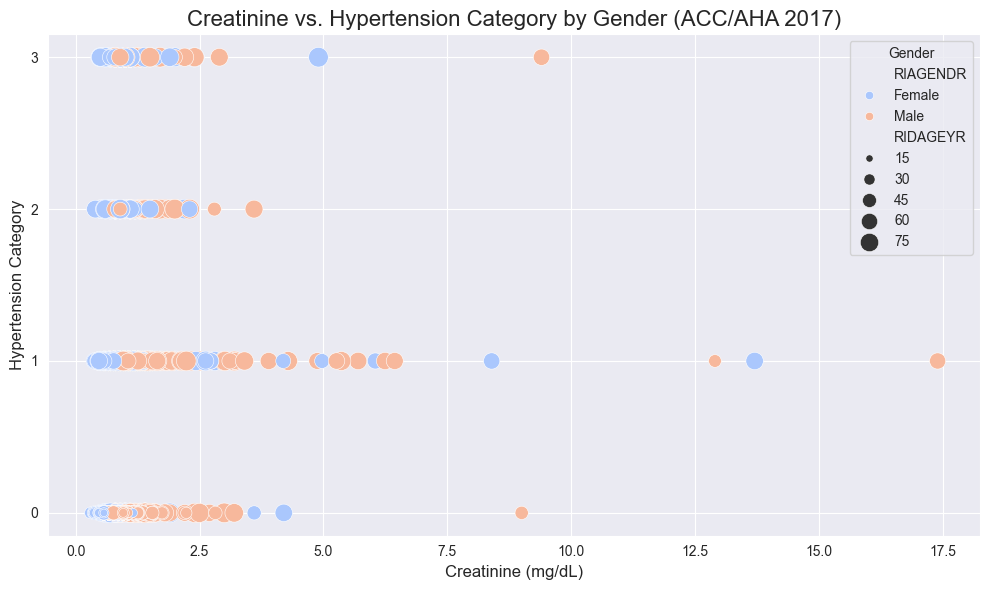

In [18]:
### Add Age as Size: Incorporate RIDAGEYR to see if age influences the distribution:

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_non_missing, x='LBXSCR', y='HTN_Category_Measured_New', hue='RIAGENDR', size='RIDAGEYR', palette='coolwarm', sizes=(20, 200))
plt.title('Creatinine vs. Hypertension Category by Gender (ACC/AHA 2017)', fontsize=16)
plt.xlabel('Creatinine (mg/dL)', fontsize=12)
plt.ylabel('Hypertension Category', fontsize=12)
plt.legend(title='Gender', loc='upper right')
plt.grid(True)
plt.yticks(ticks=[0, 1, 2, 3], labels=['0', '1', '2', '3'])
plt.gca().invert_yaxis()  # Ensure correct order
plt.tight_layout()
plt.savefig('creatinine_vs_htn_by_age.png', dpi=100)
plt.show()